## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "chapters", "00")
cd(ProjDir)

Import the dataset.

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
data = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Show the first six rows of the dataset.

In [4]:
first(data, 6)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [5]:
n = size(data, 1)
test_ind = sample(1:n, Int(floor(0.3*n)), replace=false);
train_ind = [(i) for i=1:n if !(i in test_ind)];
test = data[test_ind, :];
train = data[train_ind, :];

Save dataframe versions of our dataset.

In [6]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,145.415,37.9316,49.0,0
2,167.64,50.6889,57.0,1
3,163.195,53.0986,22.0,1
4,150.165,41.9573,22.0,0
5,160.655,54.0908,26.0,1
6,152.4,43.5448,63.0,0
7,155.575,50.9157,50.0,1
8,152.4,39.2924,49.0,0
9,145.415,39.3775,42.0,0


Create our labels. These are the values we are trying to predict.

In [7]:
train_label = train[:, :height]
test_label = test[:, :height]

105-element Array{Union{Missing, Float64},1}:
 145.415 
 167.64  
 163.195 
 150.1648
 160.655 
 152.4   
 155.575 
 152.4   
 145.415 
 140.335 
   ⋮     
 162.56  
 149.86  
 149.225 
 151.765 
 136.525 
 149.225 
 145.415 
 154.305 
 161.29  

Get the list of columns to keep.

In [8]:
remove_names = filter(x->!in(x, [:height, :age, :male]), names(data))

1-element Array{Symbol,1}:
 :weight

Filter the test and train sets.

In [9]:
train = Matrix(train[:, remove_names]);
test = Matrix(test[:, remove_names]);

A handy helper function to rescale our dataset.

In [10]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [11]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [12]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [13]:
dmat = [ones(size(train, 1)) train]

247×2 Array{Float64,2}:
 1.0  -1.27197 
 1.0   1.16956 
 1.0   2.63698 
 1.0  -1.01276 
 1.0  -1.51027 
 1.0   1.38277 
 1.0   0.705499
 1.0  -1.33886 
 1.0   0.381786
 1.0  -1.66077 
 ⋮             
 1.0   0.408671
 1.0  -0.841355
 1.0  -0.598875
 1.0  -0.632321
 1.0   0.28325 
 1.0  -1.60224 
 1.0   1.03995 
 1.0   1.32006 
 1.0   1.0943  

Bayesian linear regression.

In [14]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [15]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat);

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/00


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [16]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp
Model name=linear_regression_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/d

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[0.0031767 0.764627 0.673126; 0.00935496 0.693504 0.704679; … ; -0.00819703 0.760699 0.663769; -0.0401277 0.724761 0.706907]

Union{Missing, Float64}[-0.00799846 0.793395 0.617406; 0.0155512 0.710837 0.70414; … ; 0.0670004 0.733115 0.722578; -0.0478797 0.79053 0.644038]

Union{Missing, Float64}[-0.010396 0.821334 0.659028; -0.0574836 0.775544 0.699746; … ; 0.0913455 0.749277 0.692411; -0.0590537 0.754035 0.682091]

Union{Missing, Float64}[0.0430281 0.763027 0.633791; -0.0345916 0.775891 0.642087; … ; -0.0372693 0.798388 0.638311; 0.0339919 0.79273 0.658513]

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean          SD       Naive SE        MCSE      ESS
intercept 0.00051781436 0.041381889 0.0006543051 0.00058915191 1000
  beta[1] 0.75219760600 0.042307653 0.0006689427 0.00063942098 1000
    sigma 0.66253777350 0.029955353 0.0004736357 0.00043808055 1000

Quantiles:
              2.5%        25.0%        50.0%       75.0%       97.5%  
intercept -0.08299179 -0.026807825 0.0003180235 0.027140875 0.08515422
  beta[1]  0.66624945  0.723749750 0.7523910000 0.781067500 0.83388502
    sigma  0.60906340  0.641380750 0.6614945000 0.681993250 0.72558663



Perform multivariate OLS.

In [18]:
ols = lm(@formula(height ~ weight), train_cut)

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: height ~ 1 + weight

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   115.091   2.22458  51.736   <1e-99
weight       0.874082 0.0487677 17.9234   <1e-45


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Symbol,StatsModels.ContrastsMatrix}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:2]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

Show the first side rows of the modified dataframe.

In [22]:
remove_names = filter(x->!in(x, [:age, :male]), names(test_cut));
test_cut = test_cut[remove_names];
first(test_cut, 6)

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.height).^2);
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.height).^2);

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.height).^2);
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.height).^2);

println("\nTraining set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")


Training set:
  Bayes loss: 6591.166381499286
  OLS loss: 6591.146637619944
Test set:
  Bayes loss: 2384.913994375244
  OLS loss: 2489.1740010383223


Plot the chains.

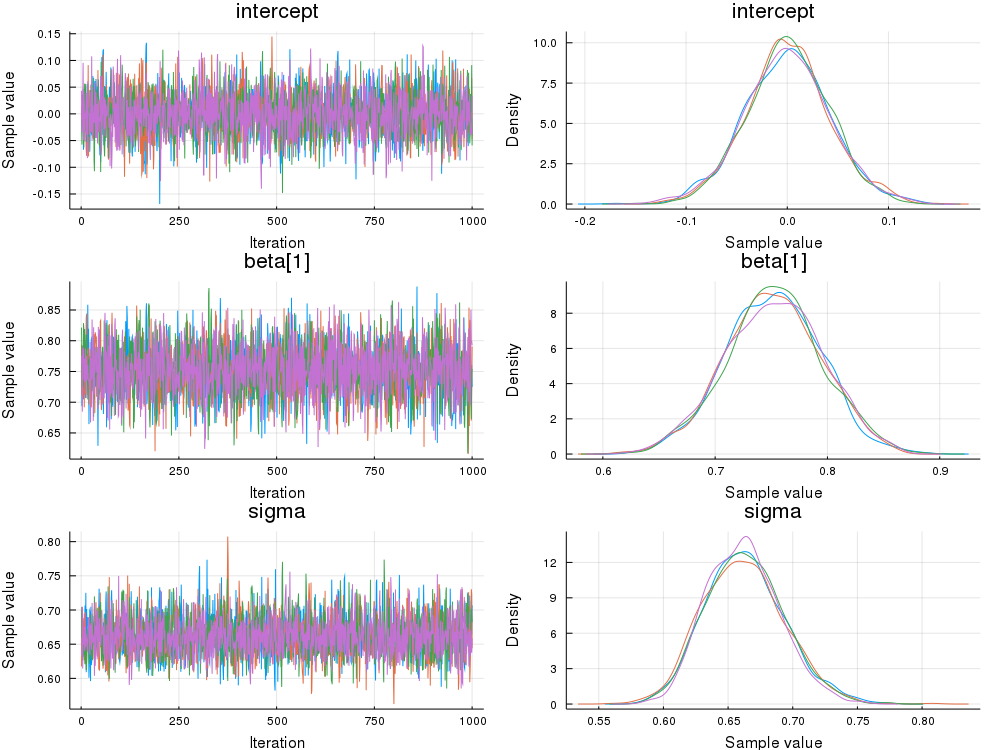

In [23]:
plot(chain)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*